## SET UP

### Mount Drive

In [8]:
import os
import sys
from google.colab import drive
drive.mount('/content/drive')
package_path = ['/content/drive/MyDrive/Packages', '/content/drive/MyDrive/github/gg_job_search', '/content/drive/MyDrive/github/gg_job_search/src/preprocessing']
sys.path.extend(package_path)
#!pip install --target=$package_path cupy-cuda102

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
sys.path

['/content',
 '/env/python',
 '/usr/lib/python310.zip',
 '/usr/lib/python3.10',
 '/usr/lib/python3.10/lib-dynload',
 '',
 '/usr/local/lib/python3.10/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.10/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/content/drive/MyDrive/Packages',
 '/content/drive/MyDrive/github/gg_job_search',
 '/content/drive/MyDrive/github/gg_job_search/src',
 '/content/drive/MyDrive/Packages',
 '/content/drive/MyDrive/github/gg_job_search',
 '/content/drive/MyDrive/github/gg_job_search/src/preprocessing']

### Load libraries

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import unicodedata

# libraries used to remove duplicates using tf-idf and cosine similarity
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

# custom functions
from preprocessing import preprocess

### Load data

In [5]:
data = pd.read_csv('/content/drive/MyDrive/github/gg_job_search/data/gg_job_search_all_RAW.csv')
data.shape

(26056, 14)

## DATA CLEANING

In [12]:
data = lowercase_and_remove_accents(data)
data = basic_cleaning(data)
data = matching_cols(data)

NameError: ignored

In [ ]:
data[(data == 'na').any(axis=1)]

,title,company_name,location,via,description,job_highlights,related_links,thumbnail,extensions,job_id,posted_at,schedule_type,date_time,search_query
3,data scientist h/f,consept informatique,nantes,via hellowork,consept informatique recherche ...\n\nintegre(...,"[{'items': [""consept informatique recherche .....",[{'link': 'https://www.google.fr/search?gl=fr&...,na,"['il y a 11 heures', '35\xa0k\xa0€ a 40\xa0k\x...",eyjqb2jfdgl0bguioijeyxrhifnjawvudglzdcbil0yilc...,il y a 11 heures,a plein temps,2023-02-17 11:50:44.355114,data engineer
5,data scientist h/f,team is,cestas,via indeed,"presentation de la societe\n\nlance en 2021, t...","[{'items': [""presentation de la societe\n\nlan...",[{'link': 'https://www.google.fr/search?gl=fr&...,na,"['il y a 14 heures', 'a plein temps']",eyjqb2jfdgl0bguioijeyxrhifnjawvudglzdcbil0yilc...,il y a 14 heures,a plein temps,2023-02-17 11:50:44.355114,data engineer
6,data scientist f/h,ombrea,aix-en-provence,via jobijoba,"le pole data, compose de 2 data scientist seni...","[{'items': ['le pole data, compose de 2 data s...",[{'link': 'https://www.google.fr/search?gl=fr&...,na,"['il y a 22 heures', 'a plein temps']",eyjqb2jfdgl0bguioijeqvrbifndsuvoveltvcbgl0gilc...,il y a 22 heures,a plein temps,2023-02-17 11:50:44.355114,data engineer
10,senior data scientist,emmerson kitney,paris,via bebee,published on 06/14/2021\n• permanent contract\...,"[{'items': [""published on 06/14/2021\n• perman...",[{'link': 'https://www.google.fr/search?gl=fr&...,na,"['il y a 20 heures', 'a plein temps']",eyjqb2jfdgl0bguioijtzw5pb3igrgf0ysbty2llbnrpc3...,il y a 20 heures,a plein temps,2023-02-17 11:50:44.774109,data engineer
13,cdi – data scientist – aerospatiale et maritime,keyseaobs,toulouse,via indeed,keyseaobs est une startup qui propose une solu...,"[{'items': [""keyseaobs est une startup qui pro...",[{'link': 'https://www.google.fr/search?gl=fr&...,na,"['il y a 15 heures', 'a plein temps']",eyjqb2jfdgl0bguioijdrekg4octierhdgegu2npzw50ax...,il y a 15 heures,a plein temps,2023-02-17 11:50:44.774109,data engineer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15401,digital data engineer (it) / freelance (h/f),communaute d'agglomeration du niortais,niort,via jobijoba,79 - niort\n\npubliee le 08/05/23 offre n° 451...,[{'items': ['79 - niort\n\npubliee le 08/05/23...,"[{'link': 'https://www.niortagglo.fr/', 'text'...",na,"['il y a 11 heures', 'prestataire']",eyjqb2jfdgl0bguioijeawdpdgfsierhdgegrw5naw5lzx...,il y a 11 heures,prestataire,2023-05-09 21:28:21.965232,data engineer
15403,data engineer snowflake,kpc - key performance consulting,bordeaux,via bebee,rejoignez la plus grosse equipe snowflake cert...,"[{'items': [""rejoignez la plus grosse equipe s...",[{'link': 'https://www.google.fr/search?hl=fr&...,na,"['il y a 15 heures', 'a plein temps']",eyjqb2jfdgl0bguioijeyxrhievuz2luzwvyifnub3dmbg...,il y a 15 heures,a plein temps,2023-05-09 21:28:34.301130,data engineer
15406,data engineer snowflake f/h,kpc - key performance consulting,lyon,via bebee,devenez notre prochain(e) data engineer snowfl...,"[{'items': [""devenez notre prochain(e) data en...",[{'link': 'https://www.google.fr/search?hl=fr&...,na,"['il y a 14 heures', 'a plein temps']",eyjqb2jfdgl0bguioijeyxrhievuz2luzwvyifnub3dmbg...,il y a 14 heures,a plein temps,2023-05-09 21:28:34.301130,data engineer
15409,senior data engineer,accor,na,via bebee,"bienvenue chez accor, groupe hotelier, leader ...","[{'items': ['bienvenue chez accor, groupe hote...","[{'link': 'http://group.accor.com/', 'text': '...",https://encrypted-tbn0.gstatic.com/images?q=tb...,"['il y a 14 heures', 'a plein temps']",eyjqb2jfdgl0bguioijtzw5pb3igrgf0ysbfbmdpbmvlci...,il y a 14 heures,a plein temps,2023-05-09 21:28:40.441406,data engineer


In [ ]:
data.job_id

Index(['title', 'company_name', 'location', 'via', 'description',
       'job_highlights', 'related_links', 'thumbnail', 'extensions', 'job_id',
       'posted_at', 'schedule_type', 'date_time', 'search_query'],
      dtype='object')

In [ ]:
# define mismatch value masks
mismatch_postedat = data.posted_at.str.slice(0,6) != "il y a"
mismatch_jobid = data.job_id.str.slice(0,6) != "eyjqb2"
mismatch_extensions = data.extensions.str.slice(0,2) != "['"
mismatch_schedule = (data.schedule_type != "a plein temps") & (data.schedule_type != "stage") & (data.schedule_type != "prestataire") & (data.schedule_type != "a temps partiel")
mismatch_datetime = data.date_time.str.slice(0,2) != "20"

# shift every column from 1 position starting at thumbnail col
matched_df = data[mismatch_datetime & mismatch_schedule & mismatch_extensions & mismatch_jobid & mismatch_postedat].iloc[:,-7:].shift(axis=1, periods=1).fillna('na')

# replace og data w/ shifted values
data.loc[mismatch_datetime & mismatch_schedule & mismatch_extensions & mismatch_jobid & mismatch_postedat, data.columns[-7:]] = matched_df.copy().values

# replace og data w/ shifted values
data.loc[mismatch_datetime & mismatch_schedule & mismatch_extensions & mismatch_jobid & mismatch_postedat, data.columns[-7:]] = matched_df.copy().values


mismatch_thumbnail = data.loc[data['job_id'].str.startswith(('https:')), data.columns[7:-4]].shift(axis=1, periods=1)

mismatch_thumbnail['thumbnail'] = data.loc[data['job_id'].str.startswith(('https:')), 'job_id']

data.loc[data['job_id'].str.startswith(('https:')), data.columns[7:-4]] = mismatch_thumbnail.copy().values


# get location col values in job_id col + shift dataframe
mismatch_cities = data.loc[~data['job_id'].str.startswith(('eyjqb2', 'il y a', 'https:', 'na'))].loc[:, 'location': 'job_id'].shift(axis=1, periods=1)

# assign these values to location col
mismatch_cities['location'] = data.loc[~data['job_id'].str.startswith(('eyjqb2', 'il y a', 'https:', 'na')), 'job_id']

# replace og data w/ newly arranged values
data.loc[~data['job_id'].str.startswith(('eyjqb2', 'il y a', 'https:', 'na')), data.columns[2:-4]] = mismatch_cities.copy().values


extensions_in_thumbnail = data[data.thumbnail.str.slice(0,6) == "['il y"].loc[:, 'thumbnail': 'job_id'].shift(axis=1, periods=1).fillna('na')

data.loc[data.thumbnail.str.slice(0,6) == "['il y", data.columns[7:-4]] = extensions_in_thumbnail.copy().values


mismatch_postedat = data.loc[~data.posted_at.str.startswith(('il y a', 'na'))][['posted_at', 'schedule_type']]

mismatch_postedat['posted_at'], mismatch_postedat['schedule_type'] = mismatch_postedat['schedule_type'], mismatch_postedat['posted_at']

data.loc[~data.posted_at.str.startswith(('il y a', 'na')), data.columns[-4:-2]] = mismatch_postedat.copy().values

In [ ]:
data

,title,company_name,location,via,description,job_highlights,related_links,thumbnail,extensions,job_id,posted_at,schedule_type,date_time,search_query
0,data scientist lead h/f,fifty-five,paris,via hellowork,fifty-five recherche ...\n\ndescription\ndata ...,"[{'items': [""fifty-five recherche ...\n\ndescr...",[{'link': 'https://www.google.fr/search?gl=fr&...,https://encrypted-tbn0.gstatic.com/images?q=tb...,"['il y a 16 heures', 'a plein temps']",eyjqb2jfdgl0bguioijeyxrhifnjawvudglzdcbmzwfkie...,il y a 16 heures,a plein temps,2023-02-17 11:50:44.355114,data engineer
1,data scientist (it) / freelance,societe free-work,gennevilliers,via linkedin,contexte : dans le cadre de plusieurs projets ...,[{'items': ['contexte : dans le cadre de plusi...,[{'link': 'https://www.google.fr/search?gl=fr&...,https://encrypted-tbn0.gstatic.com/images?q=tb...,"['il y a 17 heures', 'a plein temps']",eyjqb2jfdgl0bguioijeqvrbifndsuvoveltvcaosvqpic...,il y a 17 heures,a plein temps,2023-02-17 11:50:44.355114,data engineer
2,data analyst / data scientist h/f,grandvision france,chatenay-malabry,via figaro emploi,quelles sont les missions ?\n\nvous\navez beso...,"[{'items': [""quelles sont les missions ?\n\nvo...",[{'link': 'https://www.google.fr/search?gl=fr&...,https://encrypted-tbn0.gstatic.com/images?q=tb...,"['il y a 11 heures', 'a plein temps']",eyjqb2jfdgl0bguioijeyxrhigfuywx5c3qglybeyxrhih...,il y a 11 heures,a plein temps,2023-02-17 11:50:44.355114,data engineer
3,data scientist h/f,consept informatique,nantes,via hellowork,consept informatique recherche ...\n\nintegre(...,"[{'items': [""consept informatique recherche .....",[{'link': 'https://www.google.fr/search?gl=fr&...,na,"['il y a 11 heures', '35\xa0k\xa0€ a 40\xa0k\x...",eyjqb2jfdgl0bguioijeyxrhifnjawvudglzdcbil0yilc...,il y a 11 heures,a plein temps,2023-02-17 11:50:44.355114,data engineer
4,data scientist - industrial field,fieldbox,bordeaux,via linkedin,"as part of the data science team, you work clo...","[{'items': ['as part of the data science team,...",[{'link': 'https://www.google.fr/search?gl=fr&...,https://encrypted-tbn0.gstatic.com/images?q=tb...,"['il y a 19 heures', 'a plein temps']",eyjqb2jfdgl0bguioijeyxrhifnjawvudglzdcatieluzh...,il y a 19 heures,a plein temps,2023-02-17 11:50:44.355114,data engineer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15441,clinical data manager h/f,aixial group,france,via emplois trabajo.org,"aixial group, cro (clinical research organizat...","[{'items': [""aixial group, cro (clinical resea...","[{'link': 'http://www.aixial.com/', 'text': 'a...",https://encrypted-tbn0.gstatic.com/images?q=tb...,"['il y a 17 heures', 'a plein temps']",eyjqb2jfdgl0bguioijdbgluawnhbcbeyxrhie1hbmfnzx...,il y a 17 heures,a plein temps,2023-05-09 21:29:01.290696,data engineer
15442,ingenieur data integrity,expleo group,france,via emplois trabajo.org,qui sommes-nous ?\n\nacteur reconnu pour notre...,"[{'items': [""qui sommes-nous ?\n\nacteur recon...","[{'link': 'https://expleo.com/global/en/', 'te...",https://encrypted-tbn0.gstatic.com/images?q=tb...,"['il y a 1 heure', 'a plein temps']",eyjqb2jfdgl0bguioijjbmfdqw5pzxvyierhdgegsw50zw...,il y a 1 heure,a plein temps,2023-05-09 21:29:01.290696,data engineer
15443,cloud engineer,capgemini,paris,via emplois trabajo.org,"capgemini recherche pour sa practice c&ca, un(...","[{'items': [""capgemini recherche pour sa pract...","[{'link': 'http://www.capgemini.com/', 'text':...",https://encrypted-tbn0.gstatic.com/images?q=tb...,"['il y a 15 heures', 'a plein temps']",eyjqb2jfdgl0bguioijdbg91zcbfbmdpbmvlciisimh0aw...,il y a 15 heures,a plein temps,2023-05-09 21:29:01.290696,data engineer
15444,data engineer,astek,clermont-ferrand,via emplois trabajo.org,"le groupe astek\n\ncree en france en 1988, ast...","[{'items': [""le groupe astek\n\ncree en france...","[{'link': 'http://www.astekgroup.fr/', 'text':...",https://encrypted-tbn0.gstatic.com/images?q=tb...,"['il y a 15 heures', 'a plein temps']",eyjqb2jfdgl0bguioije

### Duplicates

Purely based job id, we can skim off a lots of duplicates. Nonetheless i still found a few of identical / near-identical job descriptions, maybe because [sometimes recruiters or companies post the same advert for a job which results in duplicate data.](https://medium.com/analytics-vidhya/data-science-job-search-using-nlp-and-lda-in-python-12ecbfac79f9)

To get rid off these ones, i will use cosine similatity between job descriptions.

In [ ]:
data.drop(['job_highlights', 'related_links', 'thumbnail', 'job_id'], axis=1, inplace=True)

#### Using cosine similarity

Before removing the remaining duplicates, i will normalize the text data for easier handling.

### Vectorizing w/ TfidfVectorizer

In [ ]:
data.date_time = pd.to_datetime(data.date_time)

In [ ]:
last_descriptions_df = data[data.date_time.dt.date == pd.Timestamp('2023-05-06').date()].reset_index(drop=True)
last_descriptions = data[data.date_time.dt.date == pd.Timestamp('2023-05-06').date()]['description']

In [ ]:
# Create a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Vectorize the text corpus using NumPy array
corpus_np = np.array(last_descriptions, dtype=str)
tfidf_matrix_np = tfidf_vectorizer.fit_transform(corpus_np)

# dataframe of tf-idf matrix
tfidf_df = pd.DataFrame(data=tfidf_matrix_np.todense(), columns=tfidf_vectorizer.get_feature_names_out())

### Compute cosine similarity

In [ ]:
# Compute cosine similarity between pairs of documents using Cupy array
cosine_sim = (tfidf_matrix_np) * (tfidf_matrix_np.T)

# convert to numpy array
cosine_sim = cosine_sim.toarray()

In [ ]:
# set 0 to diagonal array
np.fill_diagonal(cosine_sim, 0)

In [ ]:
np.save('/content/drive/MyDrive/github/gg_job_search/data/cosine_sim.npy', cosine_sim)

In [ ]:
cosine_sim = np.load('/content/drive/MyDrive/github/gg_job_search/data/cosine_sim.npy')

In [ ]:
# create df
df_cos_sim = pd.DataFrame(cosine_sim)
df_cos_sim

,0,1,2,3,4,5,6,7,8,9,...,241,242,243,244,245,246,247,248,249,250
0,0.000000,0.079220,0.035829,0.094851,0.570952,0.071654,0.029540,0.603826,0.613350,0.637752,...,0.017545,0.011614,0.004569,0.042140,0.003226,0.003372,0.025405,0.038502,0.021924,0.012881
1,0.079220,0.000000,0.284517,0.393646,0.052557,0.549910,0.236988,0.065412,0.071865,0.041039,...,0.181969,0.243139,0.133599,0.257620,0.136712,0.146407,0.265435,0.239717,0.164874,0.217008
2,0.035829,0.284517,0.000000,0.333986,0.022509,0.181000,0.407717,0.025752,0.034813,0.017347,...,0.350065,0.334707,0.290901,0.355784,0.207620,0.218475,0.432042,0.413170,0.332573,0.370474
3,0.094851,0.393646,0.333986,0.000000,0.063713,0.321019,0.294820,0.044467,0.055467,0.040977,...,0.235952,0.252664,0.252748,0.257427,0.126558,0.136494,0.338461,0.284466,0.209495,0.266660
4,0.570952,0.052557,0.022509,0.063713,0.000000,0.048255,0.048678,0.510797,0.562634,0.566726,...,0.008269,0.002870,0.011467,0.027354,0.002175,0.002273,0.021198,0.032832,0.015951,0.006921
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246,0.003372,0.146407,0.218475,0.136494,0.002273,0.090657,0.187535,0.002060,0.003043,0.003163,...,0.164860,0.153915,0.127989,0.174257,0.909708,0.000000,0.235887,0.193061,0.177673,0.192827
247,0.025405,0.265435,0.432042,0.338461,0.021198,0.177371,0.394062,0.013164,0.014210,0.029595,...,0.348342,0.344145,0.331654,0.349254,0.221612,0.235887,0.000000,0.435904,0.355742,0.377868
248,0.038502,0.239717,0.413170,0.284466,0.032832,0.149293,0.359019,0.019364,0.013591,0.015065,...,0.295994,0.304202,0.268823,0.341525,0.182367,0.193061,0.435904,0.000000,0.343518,0.323500
249,0.021924,0.164874,0.332573,0.209495,0.015951,0.123357,0.288471,0.013439,0.014780,0.017219,...,0.299973,0.257086,0.224611,0.257389,0.166847,0.177673,0.355742,0.343518,0.000000,0.308713


In [ ]:
df_cos_sim.to_csv('/content/drive/MyDrive/github/gg_job_search/data/df_cos_sim.csv')

In [ ]:
df_cos_sim =  pd.read_csv('/content/drive/MyDrive/github/gg_job_search/data/df_cos_sim.csv')

In [ ]:
cosine_sim = np.array(df_cos_sim)

In [ ]:
from scipy.sparse import coo_matrix

In [ ]:
# convert to coordinate matrix
cosine_coo = coo_matrix(cosine_sim)

In [ ]:
i = 42
pd.options.display.max_colwidth = 50
og_record = last_descriptions_df.iloc[i:i+1]
og_record

,title,company_name,location,via,description,job_highlights,related_links,thumbnail,extensions,job_id,posted_at,schedule_type,date_time,search_query
42,data analyst h/f,lynx rh,massy,via jobijoba,"description du postelynx rh essonne, cabinet d...",[{'items': ['description du postelynx rh esson...,[{'link': 'https://www.google.fr/search?gl=fr&...,na,"['il y a 12 heures', 'a plein temps']",eyjqb2jfdgl0bguioijeyxrhiefuywx5c3qgsc9giiwiah...,il y a 12 heures,a plein temps,2023-05-06 20:53:51.880113,data scientist


In [ ]:
last_descriptions_df['company_name'].value_counts()

thales           13
lynx rh           7
sanofi            5
scalian           4
pole emploi       4
                 ..
sqorus            1
randstad          1
financepeople     1
fed it            1
cognizant         1
Name: company_name, Length: 184, dtype: int64

In [ ]:
last_descriptions_df[last_descriptions_df['company_name'] == "lynx rh"].index

Int64Index([40, 42, 86, 122, 160, 169, 219], dtype='int64')

In [ ]:
k = 20

cos_val = cosine_coo.data[cosine_coo.row == i]
col_val = cosine_coo.col[cosine_coo.row == i]
top_k_indices = np.argpartition(cos_val, -k)[-k :]

top_k_col_indices = col_val[top_k_indices]
top_k_scores = cos_val[top_k_indices]

top_k_df = last_descriptions_df.copy().iloc[top_k_col_indices]
top_k_df['top_k_scores'] = top_k_scores

# sort
sorted_top_k_df = top_k_df.sort_values(by='top_k_scores', ascending=False)

# concat og_record to be compared w/ top k similar records dataframe
concat_df = pd.concat([sorted_top_k_df, og_record], axis=0)

# get job postings w/ same company name
same_company_only = concat_df[concat_df.company_name == og_record.iloc[0]['company_name']]

# fill 1  og_record['top_k_scores']
same_company_only['top_k_scores'] =  same_company_only['top_k_scores'].fillna(1)

pd.options.display.max_colwidth = 50
# filter out duplicated rows, keep only one w/ salary info if existing
same_company_only[same_company_only['top_k_scores'] > 0.0]

<ipython-input-53-ccc150c73a29>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  same_company_only['top_k_scores'] =  same_company_only['top_k_scores'].fillna(1)


,title,company_name,location,via,description,job_highlights,related_links,thumbnail,extensions,job_id,posted_at,schedule_type,date_time,search_query,top_k_scores
40,data analyst h/f,lynx rh,massy,via jobijoba,"lynx rh essonne, cabinet de recrutement en cdi...","[{'items': [""lynx rh essonne, cabinet de recru...",[{'link': 'https://www.google.fr/search?gl=fr&...,na,"['il y a 22 heures', 'a plein temps']",eyjqb2jfdgl0bguioijeyxrhiefuywx5c3qgsc9giiwiah...,il y a 22 heures,a plein temps,2023-05-06 20:53:51.880113,data scientist,0.574640
122,data analyst,lynx rh,massy,via emplois trabajo.org,entreprise : lynx rh : recrutement specialise ...,"[{'items': [""entreprise : lynx rh : recrutemen...",[{'link': 'https://www.google.fr/search?hl=fr&...,https://encrypted-tbn0.gstatic.com/images?q=tb...,"['il y a 13 heures', 'a plein temps']",eyjqb2jfdgl0bguioijeyxrhigfuywx5c3qilcjodglkb2...,il y a 13 heures,a plein temps,2023-05-06 20:55:24.909627,data analyst,0.553800
86,data analyst (h/f),lynx rh,essonne,via jobrapido.com,informatique dsi - direction des systmes d'inf...,"[{'items': [""informatique dsi - direction des ...",[{'link': 'https://www.google.fr/search?hl=fr&...,na,"['il y a 21 heures', 'a plein temps']",eyjqb2jfdgl0bguioijeqvrbiefoquxzu1qgkegvrikilc...,il y a 21 heures,a plein temps,2023-05-06 20:54:59.613611,data analyst,0.376507
169,data engineer h/f,lynx rh,nantes,via fr.talent.com,description du postele cabinet lynx rh recherc...,"[{'items': [""description du postele cabinet ly...",[{'link': 'https://www.google.fr/search?hl=fr&...,na,"['il y a 21 heures', 'a plein temps']",eyjqb2jfdgl0bguioijeyxrhievuz2luzwvyiegvriisim...,il y a 21 heures,a plein temps,2023-05-06 20:56:31.934439,data engineer,0.203035
219,data engineer h/f,lynx rh,nantes,via emplois trabajo.org,description du postele cabinet lynx rh recherc...,"[{'items': [""description du postele cabinet ly...",[{'link': 'https://www.google.fr/search?hl=fr&...,https://encrypted-tbn0.gstatic.com/images?q=tb...,"['il y a 5 heures', 'a plein temps']",eyjqb2jfdgl0bguioijeyxrhievuz2luzwvyiegvriisim...,il y a 5 heures,a plein temps,2023-05-06 20:57:53.105301,data engineer,0.203035
42,data analyst h/f,lynx rh,massy,via jobijoba,"description du postelynx rh essonne, cabinet d...",[{'items': ['description du postelynx rh esson...,[{'link': 'https://www.google.fr/search?gl=fr&...,na,"['il y a 12 heures', 'a plein temps']",eyjqb2jfdgl0bguioijeyxrhiefuywx5c3qgsc9giiwiah...,il y a 12 heures,a plein temps,2023-05-06 20:53:51.880113,data scientist,1.000000


### Reduction of dimensionality

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
# Perform PCA on the data
pca = PCA(n_components=2)
cosine_sim_pca = pca.fit_transform(cosine_sim)

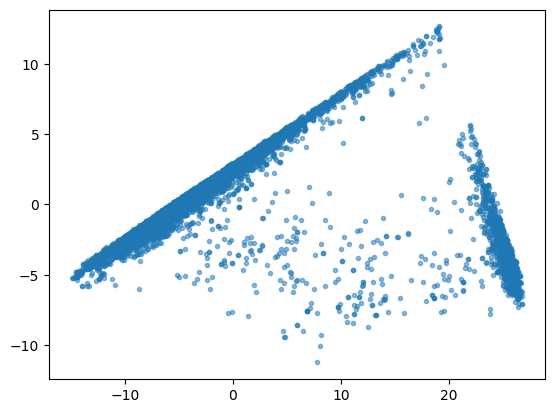

In [ ]:
# Create a figure and axes object
fig, ax = plt.subplots()

# Create a scatter plot using Seaborn, but specify the axis object to use
ax.scatter(cosine_sim_pca[:, 0], cosine_sim_pca[:, 1], alpha=0.5, marker='.')

# Show the plot
plt.show()

### Scatterplot of cosine similarity matrix

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score

In [ ]:
# Define a range of eps and min_samples values to search over
param_grid = {
    'eps': [0.1, 0.5, 1.0],
    'min_samples': [2, 5, 10]
}

# Create a GridSearchCV object with DBSCAN as the estimator
grid_search = GridSearchCV(estimator=DBSCAN(), param_grid=param_grid, scoring=silhouette_score)

# Fit GridSearchCV to the data and print the best hyperparameters
grid_search.fit(cosine_sim)
print("Best hyperparameters:", grid_search.best_params_)

### Get inflexion point

In [ ]:
start = data.company_name.nunique()
stop = int(len(data)*0.97) - 1  # subtract 1 to include the stop value
step = int(len(data)/100)
len(range(start, stop, step))

70

In [ ]:
def fit_curve(x, a, b, c):
    return a * cp.exp(-b * x) + c

wcss = []
for i in progress_bar(range(start, stop, step)):
    km = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    km.fit(cp.asnumpy(cosine_sim))
    wcss.append(km.inertia_)

x = cp.arange(1, 11)
y = cp.array(wcss)

popt, _ = curve_fit(fit_curve, x, y)
fit_y = fit_curve(x, *popt)

d2y = cp.gradient(cp.gradient(fit_y))
peaks, _ = find_peaks(cp.asnumpy(d2y))

inflection_point = peaks[0] + 1
print("Inflexion point:", inflection_point)


In [ ]:
from sklearn.metrics import silhouette_score

silhouette_scores = []
for n_clusters in range(2, 11):
    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = clusterer.fit_predict(tfidf_matrix)
    silhouette_avg = silhouette_score(tfidf_matrix, cluster_labels)
    silhouette_scores.append(silhouette_avg)

best_n_clusters = np.argmax(silhouette_scores) + 2
print("Best number of clusters:", best_n_clusters)


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

KeyboardInterrupt: ignored

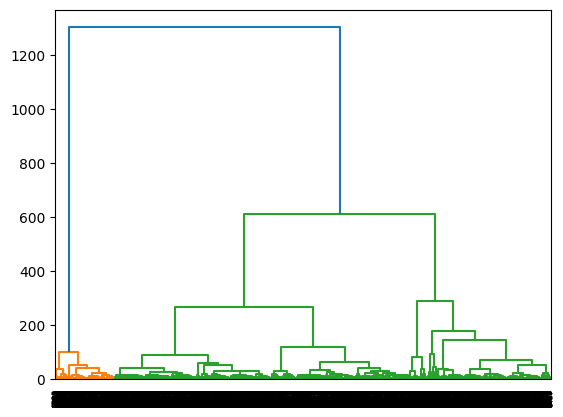

In [ ]:
# Compute pairwise distances from the cosine similarity matrix
distances = 1 - cosine_sim

# Compute hierarchical clustering using precomputed distances
linkage_matrix = hierarchy.linkage(distances, method='ward')

# Plot dendrogram
dendrogram = hierarchy.dendrogram(linkage_matrix)

In [ ]:
# Determine the optimal number of clusters
max_d = 0.5  # set the distance threshold
num_clusters = len(hierarchy.fcluster(linkage_matrix, max_d, criterion='distance'))

9840

In [ ]:
# Perform agglomerative clustering
n_clusters = None  # set to None to automatically determine the number of clusters
clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward', affinity='euclidean').fit(distances)

# Print the cluster labels
print(clustering.labels_)


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


ValueError: ignored

In [ ]:
### removing duplicates based on cosine similarity between 
## job descriptions (code from Thomas Caffrey, see link above)

# Defining our collection of job description texts to tokenize
data.description = data['description'].fillna('')
corpus = data['description']

# instantiate CountVectorizer object
count_vect = CountVectorizer()

# Fit_transform to vectorize each job description (map terms to feature indices)
X_train_counts = count_vect.fit_transform(corpus)

# Compute cosine similarities and put it in dataframe
cos_df = pd.DataFrame(cosine_similarity(X_train_counts))


## reshape dataframe for easier comparison

# get arrays of rows indices and col indices from col_df.shape
i, j = np.indices(cos_df.shape).reshape(2,-1)

# reshape values to get a 1D array 
cos_values = cos_df.values.reshape(-1)

cos_sim_df = pd.DataFrame({'i': i, 'j': j, 'sim':cos_values})

# get cosine similarity values only above 0.98 
cos_rem = cos_sim_df[(cos_sim_df['sim'] > 0.90) & (i!=j)]

# Method to remove duplicates but keep first instance:
# Trying to drop duplicates on i and j columns won't work as the row numbers of duplicates are either in i or j not both.
# Setting another column that combines the i & j values ensures that duplicates can be dropped.

cos_rem['i*j'] = cos_rem['i'] * cos_rem['j']
drop_rows = np.unique(cos_rem.drop_duplicates('i*j')['i'].values)

# keep only non-duplicated job postings
data = data[~data.index.isin(drop_rows)] 
data.reset_index(inplace=True)

print('Search query results :\n', data.search_query.value_counts(), '\n', '='*70)
print('Number of duplicates (based on cosine similarity) : ' ,drop_rows.shape[0])
print('Final number of rows : ', data.shape[0])
print('Final number of columns : ', data.shape[1])

KeyboardInterrupt: ignored

### Text normalization of job descriptions

There are several reasons to text normalization, one is to reduce noise in data. Job descriptions contains a lot of irrelevant information such as punctuation, numbers, special characters, and stop words. By normalizing the data, it'll be easier for further analysis.

In [ ]:
# get common stopwords from nltk library in both french and english
stop_words = list(set(stopwords.words('french')).union(set(stopwords.words('english'))))

punct_mark = ["•"]

apostrophes_stop_words = ["d'", "c'", "j'", "m'", "n'", "s'", "t'", "l'" ,"qu'", 
                          "jusqu'", "lorsqu'", "puisqu'", "quoiqu'", "qu'il", 
                          "qu'on", "qu'un", "qu'une", "sans qu'", "étant qu'",
                         "qu’", "jusqu’", "lorsqu’", "puisqu’", "quoiqu’", 
                          "qu’il", "qu’on", "qu’un", "qu’une", "sans qu’", "étant qu’",
                         "d’", "c’", "j’", "m’", "n’", "s’", "t’", "d’un", "d’une", "c’est"]
additional_fr_stop_words = [
    "au", "aux", "avec", "ce", "ces", "dans", "de", "des", "du", "elle",
    "en", "et", "eux", "il", "je", "la", "le", "leur", "lui", "ma",
    "mais", "me", "même", "mes", "moi", "mon", "ne", "nos", "notre",
    "nous", "on", "ou", "par", "pas", "pour", "qu", "que", "qui", "sa",
    "se", "ses", "son", "sur", "ta", "te", "tes", "toi", "ton", "tu",
    "un", "une", "vos", "votre", "vous", "c’", "d’", "j’", "l’", "à", "m’",
    "n’", "s’", "t’", "y’", "été", "étée", "étées", "étés", "étant", "suis",
    "es", "est", "sommes", "êtes", "sont", "serai", "seras", "sera",
    "serons", "serez", "seront", "serais", "serait", "serions", "seriez",
    "seraient", "étais", "était", "étions", "étiez", "étaient", "fus",
    "fut", "fûmes", "fûtes", "furent", "sois", "soit", "soyons", "soyez",
    "soient", "fusse", "fusses", "fût", "fussions", "fussiez", "fussent",
    "ayant", "eu", "eue", "eues", "eus", "ai", "as", "avons", "avez",
    "ont", "aurai", "auras", "aura", "aurons", "aurez", "auront", "aurais",
    "aurait", "aurions", "auriez", "auraient", "avais", "avait", "avions",
    "aviez", "avaient", "eut", "eûmes", "eûtes", "eurent", "aie", "aies",
    "ait", "ayons"]

all_stop_words = set(stop_words + apostrophes_stop_words + additional_fr_stop_words + punct_mark)
all_stop_words = list(all_stop_words)


# Copy the original description column to a new column
data['description_normalized'] = data['description'].copy().str.lower()

pattern = r"(\b\w+)[`'’](\w+)?\b"
replacement = r"\2"

data['description_normalized'] = data['description_normalized'].str.replace(pattern, replacement, regex=True)


# remove stop words in data.description_normalized
data['description_normalized'] = data['description_normalized'].apply(lambda text: ' '.join([word for word in text.split() if word not in all_stop_words]))
    
# remove tabulation and punctuation
data['description_normalized'] = data['description_normalized'].str.replace('[^\w\s]',' ', regex=True)
    
# Remove punctuation
translator = str.maketrans('', '', string.punctuation)
data['description_normalized'] = data['description_normalized'].apply(lambda text: text.translate(translator))
    
# lemmatization

# Load the French language model
nlp = spacy.load("fr_core_news_lg")

# Define a custom tokenizer rule for "data"
#special_cases = [{ORTH: "data", 'LEMMA': "data"}]
#nlp.tokenizer.add_special_case("data", special_cases)

def lemmatize_description_normalized(text):
    # Apply Spacy's tokenizer to the text
    doc = nlp(text)
    
    # Lemmatize each token in the document, taking into account context
    lemmas = [token.lemma_ if token.pos_ != 'VERB' and token.text != 'data' else token.text for token in doc]
    
    # Join the lemmas back into a string
    return ' '.join(lemmas)

data['description_normalized'] = data['description_normalized'].apply(lambda text: lemmatize_description_normalized(text))

Now, that our job descriptions are normalized, we can analyze them more precisely. In order to that, i'll use : N-grams tokenization and Word cloud.